In [1]:
# autoreload magic
%load_ext autoreload
%autoreload 2

In [ ]:
from mldec.codes import pauli_decoding_stim, toric_code
import stim

from itertools import chain, combinations
from functools import reduce
import numpy as np
import itertools
from pymatching import Matching


In [102]:
x_generators, z_generators, Hx, Hz = toric_code.rotated_surface_code_stabilizers(3)
generators = x_generators + z_generators


t = stim.Tableau.from_stabilizers(generators, allow_redundant=True, allow_underconstrained=True)
# we leave out the final stabilizer that canonically represents the degree of 
# freedom for a state we didn't specify
generators_S = [t.z_output(k) for k in range(len(t) - 1)] # stabilizer generators, ordered X type then Z type
generators_T = [t.x_output(k) for k in range(len(t) - 1)] # pure error generators, arbitrary order
generators_L = toric_code.rotated_toric_code_logicals(3) # logicals, ordered X type then Z type

print("Generators:")
for g in generators_S:
    print(g)
print("pure errors:")
for g in generators_T:
    print(g)
print("Logical operators:")
for g in generators_L:
    print(g)


Generators:
+XX_XX____
+____XX_XX
+__X__X___
+___X__X__
+___ZZ_ZZ_
+_ZZ_ZZ___
+ZZ_______
+_______ZZ
pure errors:
+Z________
+Z___Z____
+__Z______
+Z__Z_____
+______X__
+_____X___
+_X___X___
+______XX_
Logical operators:
+___XXX___
+_Z__Z__Z_


In [293]:
np.unpackbits(np.array([256]).view(np.uint8), bitorder='little', count=9)

array([0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=uint8)

In [453]:

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))


def operator_sequence_to_stim(lst, n):
    if len(lst) > 0:
        out = reduce(lambda P, Q: P*Q, lst)
    else:
        out = stim.PauliString("_" * n) 
    return out


def build_lst_lookup_and_mle(generators_S, generators_T, generators_L, Hx, Hz, noise_model):
    """Starting from STL, create a lookup table mapping an error to a (syndrome, ell) pair.

    Note: The S,L generators are expected to be [logical_xs, logical_zs] 
    errors in returned hash are binary symplectic form

    Conventions:
     - sigma_z means syndromes for z-stabilizer violations

    TIE-BREAKING: If there are multiple cosets with the same probability, there is no consistent
    way to break ties so that MWPM matches MLE in the iid situation. So, we will return
    the set of all cosets that are tied for the most likely. This means the mle_lookup will
    be ragged, and should be handled carefully.


    Args:
        generators_S: list of generators of the stabilizer group
        generators_T: list of pure errors
        generators_L: list of logical Pauli operators
        Hx, Hz: PCMs for the x- and z-stabilizers
    
    Returns: This is a two-for-one function, returning both the LST lookup table and the MLE lookup table
        lst: a dictionary mapping errors to (syndrome, ell) pairs
            {(error_x, error_z): (np.array([syndrome_x, syndrome_z]), np.array([logical_x, logical_z]))}
                error_x: shape n
                syndrome_x: shape r
                logical_x: shape k
            where syndrome_x is the syndrome for x-stabilizers (in order)
            logical_x is a bitmask for logical operators in logical_x
        mle: a dictionary mapping syndromes to the set of most likely logical _errors_
            {(syndrome_x, syndrome_z): [np.array([logical_x, logical_z]), ...]}
    
    """

    # about 6 seconds

    r = len(generators)
    n = len(generators[0])
    k = n - r
    assert len(generators_L) == 2*k
    assert len(generators_T) == r
    lst = {}
    mle = {}
    err_prs = {}
    mle_acc = 0
    for a, pure_error_lst in enumerate(powerset(generators_T)):
        pure_error = operator_sequence_to_stim(pure_error_lst, n)
        xerr, zerr = pure_error.to_numpy()
        if len(xerr) == 0 and len(zerr) == 0:
            xerr = np.zeros(n, dtype=int)
            zerr = np.zeros(n, dtype=int)
        sigma_z = (Hz @ xerr) % 2
        sigma_x = (Hx @ zerr) % 2
        sigma = np.concatenate((sigma_x, sigma_z), axis=0)
        # if not np.allclose(sigma, np.array((1,1,1,1,0,0,1,0))):
        #     continue
        # we will fill up logical_probs with corresponding total probabilities, then pick the biggest
        # the logical masks are [logical_x, logical_z] bitmasks
        logical_probs = np.zeros(4**k)
        logical_masks = np.array(list(itertools.product([0, 1], repeat=2*k)))
        for b, logical_mask in enumerate(logical_masks):
            # to enumerate over the logicals, we want to preserve their order 
            # as provided in generators_L, as this will determine the binary
            # mask representing that logical
            logical_op_lst = [generators_L[i] for i, bit in enumerate(logical_mask) if bit]
            logical_op = operator_sequence_to_stim(logical_op_lst, n)
            for c, stabilizer_lst in enumerate(powerset(generators_S)):
                stabilizer = operator_sequence_to_stim(stabilizer_lst, n)
                error = pure_error * logical_op * stabilizer
                error_symplectic = np.concatenate(error.to_numpy(), axis=0).astype(int)
                p_err = noise_model(n, error_symplectic)
                err_key = tuple(error_symplectic)
                err_prs[err_key] = p_err
                lst[err_key] = (sigma, np.array(logical_mask))
                logical_probs[b] += p_err
        # no tiebreak, just return everything that is consistent.
        best = logical_probs.max()
        mle_acc += best
        rtol = 1e-6
        winners = np.nonzero(np.isclose(logical_probs, best, rtol=rtol))[0]
        mle[tuple(sigma)] = logical_masks[winners]


    return lst, mle, mle_acc, err_prs


# def build_lst_lookup_and_mle_bitpacked(generators_S, generators_T, generators_L, Hx, Hz, noise_model, config):
#     """Starting from STL, create a lookup table mapping an error to a (syndrome, ell) pair.

#     Note: The S,L generators are expected to be [logical_xs, logical_zs] 
#     errors in returned hash are binary symplectic form

#     Conventions:
#      - sigma_z means syndromes for z-stabilizer violations
#      - bitstrings will be stored bitpacked via np.packbits(..., bitorder='little')
#         matching stim's convention

#     TIE-BREAKING: If there are multiple cosets with the same probability, there is no consistent
#     way to break ties so that MWPM matches MLE in the iid situation. So, we will return
#     the set of all cosets that are tied for the most likely. This means the mle_lookup will
#     be ragged, and should be handled carefully.


#     Args:
#         generators_S: list of generators of the stabilizer group
#         generators_T: list of pure errors
#         generators_L: list of logical Pauli operators
#         Hx, Hz: PCMs for the x- and z-stabilizers
    
#     Returns:  both the LST lookup table and the MLE lookup table
#         lst: an array containing (syndrome, logical_op pairs for each error).
#             The array is shape (2**n, 2**n, 2**(n+k)). The first dimension is indexed by bitpacked error, and the
#             second dimension contains a bitstring ([sigma_x, sigma_z, logical_x, logical_z])
#         mle: a dictionary mapping syndromes 
        
#         a dictionary mapping errors to (syndrome, ell) pairs
#             {(error_x, error_z): (np.array([syndrome_x, syndrome_z]), np.array([logical_x, logical_z]))}
#                 error_x: shape n
#                 syndrome_x: shape r
#                 logical_x: shape k
#             where syndrome_x is the syndrome for x-stabilizers (in order)
#             logical_x is a bitmask for logical operators in logical_x
#         mle: a dictionary mapping syndromes to the set of most likely logical _errors_
#             {(syndrome_x, syndrome_z): [np.array([logical_x, logical_z]), ...]}
    
#     """

#     # about 6 seconds

#     r = len(generators)
#     n = len(generators[0])
#     k = n - r
#     assert len(generators_L) == 2*k
#     assert len(generators_T) == r
#     lst = np.zeros((2 ** n, 2**n, n + k)).astype(np.uint8)
#     err_prs = np.zeros((2 ** n, 2 ** n))
#     mle = {}
#     mle_acc = 0
#     for a, pure_error_lst in enumerate(powerset(generators_T)):
#         pure_error = operator_sequence_to_stim(pure_error_lst, n)
#         xerr, zerr = pure_error.to_numpy()
#         if len(xerr) == 0 and len(zerr) == 0:
#             xerr = np.zeros(n, dtype=np.uint8)
#             zerr = np.zeros(n, dtype=np.uint8)
#         sigma_z = (Hz @ xerr) % 2
#         sigma_x = (Hx @ zerr) % 2
#         sigma = np.concatenate((sigma_x, sigma_z), axis=0).astype(np.uint8)
#         # we will fill up logical_probs with corresponding total probabilities, then pick the biggest
#         # the logical masks are [logical_x, logical_z] bitmasks
#         logical_probs = np.zeros(4**k)
#         logical_masks = np.array(list(itertools.product([0, 1], repeat=2*k)))
#         for b, logical_mask in enumerate(logical_masks):
#             # to enumerate over the logicals, we want to preserve their order 
#             # as provided in generators_L, as this will determine the binary
#             # mask representing that logical
#             logical_op_lst = [generators_L[i] for i, bit in enumerate(logical_mask) if bit]
#             logical_op = operator_sequence_to_stim(logical_op_lst, n)
#             for c, stabilizer_lst in enumerate(powerset(generators_S)):
#                 stabilizer = operator_sequence_to_stim(stabilizer_lst, n)
#                 error = pure_error * logical_op * stabilizer
#                 error_bitpack = error.to_numpy(bit_packed=True)
#                 p_err = noise_model(n, error_bitpack)
#                 err_prs[error_bitpack[0], error_bitpack[1]] = p_err
#                 print(error_bitpack[0], error_bitpack[1])
#                 lst[error_bitpack[0], error_bitpack[1]] = np.concatenate((sigma, logical_mask), axis=0).astype(np.uint8)
#             if b > 10:
#                 break
#         if c > 10:
#             break
        
#         # no tiebreak, just return everything that is consistent with MLD
#         best = logical_probs.max()
#         mle_acc += best
#         rtol = 1e-6
#         winners = np.nonzero(np.isclose(logical_probs, best, rtol=rtol))[0]
#         mle[tuple(sigma)] = logical_masks[winners]


#     return lst, mle, mle_acc, err_prs

def build_mwpm_lookup(L, Hx, Hz, generators_L, lookup):
    """Create a lookup table for the output of MWPM decoding that error.
    
    Args:
        L: the side length of the lattice
        Hx, Hz: the parity check matrices for the x- and z-stabilizers
        generators_L: the logical operators
        lookup: A lookup mapping errors to (syndrome, logical) pairs. Since we're computing 
            this anyways, we can save time on Gaussian elim to find a logical op coset containing
            to each mwpm error prediction
    Returns
        dct: a dictionary mapping
            {(syndrome_x, syndrome_z): np.array([logical_x, logical_z])}

    """
    x_logical, z_logical = generators_L
    x_logical = x_logical.to_numpy()[0]
    z_logical = z_logical.to_numpy()[1]
    if L != 3:
        raise NotImplementedError("Only L=3 is supported for now")
    
    n = L ** 2
    # generate a matching object specific to the PCM for x-stabilizers
    matching_x = Matching(Hx)
    matching_z = Matching(Hz)
    out = {}
    for i, sigma_x in enumerate(itertools.product([0, 1], repeat=4)): # syndrome for z-type errors i.e. x-stabilizer violations
        zerr_pred = matching_x.decode(np.array(sigma_x))
        for j, sigma_z in enumerate(itertools.product([0, 1], repeat=4)): # x-type errors, i.e. z-stabilizer violations
            xerr_pred = matching_z.decode(np.array(sigma_z))
            # MWPM has predicted the error, now we determine which logical coset this belongs to.
            err_pred = np.concatenate((xerr_pred, zerr_pred), axis=0)
            _, logical_op = lookup[tuple(err_pred)]
            out[tuple(sigma_x + sigma_z)] = logical_op
    return out

# def build_mwpm_lookup_bitpacked(L, Hx, Hz, generators_L, lookup):
#     """Create a lookup table for the output of MWPM decoding that error.
    
#     Args:
#         L: the side length of the lattice
#         Hx, Hz: the parity check matrices for the x- and z-stabilizers
#         generators_L: the logical operators
#         lookup: An array (2**n 2**n, n+k) of (syndrome, logical) pairs for error at index (bitpack_x, bitpack_z)
#     Returns
#         dct: a dictionary mapping
#             {(syndrome_x, syndrome_z): np.array([logical_x, logical_z])}

#     """
#     x_logical, z_logical = generators_L
#     x_logical = x_logical.to_numpy()[0]
#     z_logical = z_logical.to_numpy()[1]
#     if L != 3:
#         raise NotImplementedError("Only L=3 is supported for now")
#     k = 1
#     n = L ** 2
#     # generate a matching object specific to the PCM for x-stabilizers
#     matching_x = Matching(Hx)
#     matching_z = Matching(Hz)
#     out = {}
#     for i, sigma_x in enumerate(itertools.product([0, 1], repeat=4)): # syndrome for z-type errors i.e. x-stabilizer violations
#         zerr_pred = matching_x.decode(np.array(sigma_x))
#         for j, sigma_z in enumerate(itertools.product([0, 1], repeat=4)): # x-type errors, i.e. z-stabilizer violations
#             xerr_pred = matching_z.decode(np.array(sigma_z))
#             # MWPM has predicted the error, now we determine which logical coset this belongs to.
#             x_idx, z_idx = pack_bits_anydtype((xerr_pred, zerr_pred))
#             logical_op = lookup[x_idx, z_idx][n-k:]           
#             out[tuple(sigma_x + sigma_z)] = logical_op
#     return out

# np.unpackbits(np.array([256, 44]).reshape(-1, 1).view(np.uint8), bitorder='little', count=9, axis=1)
# np.logical_or(*np.unpackbits(np.array([256, 44]).reshape(-1, 1).view(np.uint8), bitorder='little', count=9, axis=1))


In [449]:
        
# def noise_model(n, err, config):
#     """
#     Args:
#         error: [error_x, error_z] with length 2n
#     """

#     p = config.get('p')
#     wt = sum(np.logical_or(err[:n], err[n:]))
#     out = (p/3)**wt * (1-p)**(n-wt)
#     return out


# def weight_bitpacked(err):
#     """Compute the weight of a bitpacked error [i_x, i_z]"""
#     x = np.unpackbits(err[0].view(np.uint8), bitorder='little', count=n)
#     z = np.unpackbits(err[1].view(np.uint8), bitorder='little', count=n)
#     is_err = np.logical_or(x, z)
#     wt = np.sum(is_err)
#     return wt

# def pack_bits_anydtype(tup):
#     """convert binary representation to integers.
    
#     little bitorder 'bitpacking' but for any dtype, not just uint8
    
#     Consistent with bitorder=little for unpackbits
#     """
#     x, z = tup
#     return(x.dot(1 << np.arange(x.shape[-1])), z.dot(1 << np.arange(z.shape[-1])))
#     # out = arr.dot(1 << np.arange(arr.shape[-1]))
#     # return (np.array(out[0]), np.array(out[1]))

# def unpack_bits(err, n):
#     """Convert integers to binary representation"""
#     i_x, i_z = err
#     return np.unpackbits(np.array([i_x, i_z]).reshape(-1, 1).view(np.uint8), bitorder='little', count=n, axis=1)

# def make_noise_model_bitpacked(config):
#     p = config.get('p')
#     alpha = config.get('alpha')
#     def noise_model_bitpacked(n, err):
#         """
#         Args:
#             error: bitpacked [error_x, error_z]
#         """

#         wt = weight_bitpacked(err)
#         out = (p/3)**wt * (1-p)**(n-wt)
#         return out
#     return noise_model_bitpacked

def make_noise_model(config):
    p = config.get('p')
    alpha = config.get('alpha')
    def noise_model(n, err):
        """
        Args:
            error: [error_x, error_z] with length 2n
        """

        wt = sum(np.logical_or(err[:n], err[n:]))
        out = (p/3)**wt * (1-p)**(n-wt)
        return out
    return noise_model

def biased_noise_model(n, err, config):
    """
    Biased noise model where half of the qubits are more likely to depolarize
    """
    p = config.get('p')
    alpha = config.get('alpha')
    p1 = p
    p2 = p * alpha
    err_str = np.logical_or(err[:n], err[n:])
    p_first = np.prod((p1/3)*err_str[:n//2] +(1-p1)*(1-err_str[:n//2]))
    p_second = np.prod((p2/3)*err_str[n//2:] + (1-p2)*(1-err_str[n//2:]))
    return np.multiply(p_first, p_second)

# print(pack_bits_anydtype(unpack_bits((np.array([44]), np.array([22])), 9)))
# print(unpack_bits(pack_bits_anydtype((np.array([0,0,1,0]), np.array([0,0,0,0]))), 4))

In [454]:
L = 3
noise_config = {'p': 0.1, 'alpha':0.5}
noise_model = make_noise_model(noise_config)
lst, mle_lookup, mle_acc, err_prs = build_lst_lookup_and_mle(generators_S, generators_T, generators_L, Hx, Hz, noise_model)


In [455]:
mwpm_lookup = build_mwpm_lookup(L, Hx, Hz, generators_L, lst)

In [ ]:
# bitpacked garbage
n = L**2
k = 1
weights = np.arange(0, n+1)
unimportant_prs = np.zeros(n+1)
bad_prs = np.zeros(n+1)
important_prs = np.zeros(n+1)
tot = 0
for i_x in range(2 ** n):
    for i_z in range(2 ** n):
        p_err = err_prs[i_x, i_z]
        tot += p_err
        continue
        syndrome, logical = lst[i_x,i_z,:n-k], lst[i_x,i_z,n-k:]
        syndrome = tuple(syndrome)
        logical_mles = mle_lookup[syndrome]
        logical_mwpm = mwpm_lookup[syndrome]
        err = unpack_bits((i_x, i_z), n)
        wt = weight_bitpacked(err)

        print(logical)
        print(logical_mles)
        print(logical_mwpm)
        print(logical in logical_mles)
    #     break
    # break
        f0_is_correct =  np.allclose(logical, logical_mwpm)
        # break importance ties arbitrarily/
        # FIXME: what should i do here

        # THIS IS THE BOTTLENECK:
        fstar_is_maybe_correct = (logical in logical_mles)
        if fstar_is_maybe_correct:
            if not f0_is_correct:
                important_prs[wt] += p_err / len(logical_mles)
            else:
                unimportant_prs[wt] += p_err
        else:
            bad_prs[wt] += p_err
print(tot)
            

In [ ]:
# compute the syndrome probabilities and syndrome weight distributions

def build_syndrome_probs_and_weight_distr(generators_S, generators_T, generators_L, Hx, Hz, noise_model):
    """Compute a table of syndrome probabilities, and a table of error weight distribution by syndrome.

    Returns:
        p_SL: a dictionary mapping (sigma, ell) to the probability of that pair
        hist_SL_wts: a dictionary mapping (sigma, ell) an (n+1) array of weights, where the ith entry is the 
            cum. probability of errors in that coset enumerator having weight i
    """

    p_SL = {}
    hist_SL_wts = {}

    r = len(generators)
    n = len(generators[0])
    k = n - r
    assert len(generators_L) == 2*k
    assert len(generators_T) == r
    for a, pure_error_lst in enumerate(powerset(generators_T)):
        pure_error = operator_sequence_to_stim(pure_error_lst, n)
        xerr, zerr = pure_error.to_numpy()
        sigma_z = (Hz @ xerr) % 2
        sigma_x = (Hx @ zerr) % 2
        sigma = np.concatenate((sigma_x, sigma_z), axis=0)
        p_sigma = 0
        logical_masks = np.array(list(itertools.product([0, 1], repeat=2*k)))
        for b, logical_mask in enumerate(logical_masks):
            # to enumerate over the logicals, we want to preserve their order 
            # as provided in generators_L, as this will determine the binary
            # mask representing that logical
            p_SL[(tuple(sigma), tuple(logical_mask))] = 0
            hist_SL_wts[(tuple(sigma), tuple(logical_mask))] = np.zeros(n+1)
            logical_op_lst = [generators_L[i] for i, bit in enumerate(logical_mask) if bit]
            logical_op = operator_sequence_to_stim(logical_op_lst, n)
            for c, stabilizer_lst in enumerate(powerset(generators_S)):
                stabilizer = operator_sequence_to_stim(stabilizer_lst, n)
                error = pure_error * logical_op * stabilizer
                error_symplectic = np.concatenate(error.to_numpy(), axis=0).astype(int)
                p_err = noise_model(n, error_symplectic)
                wt = sum(np.logical_or(error_symplectic[:n], error_symplectic[n:]))

                # increment the probability of this (sigma, ell) pair, and the weight enumerator for this
                p_SL[(tuple(sigma), tuple(logical_mask))] += p_err
                hist_SL_wts[(tuple(sigma), tuple(logical_mask))][wt] += p_err
            

    return p_SL, hist_SL_wts

In [507]:
p_SL, hist_SL_wts = build_syndrome_probs_and_weight_distr(generators_S, generators_T, generators_L, Hx, Hz, noise_model)

In [557]:


n = L**2
weights = np.arange(0, n+1)
unimportant_prs = np.zeros(n+1)
bad_prs = np.zeros(n+1)
important_prs = np.zeros(n+1)

for syndrome in itertools.product([0, 1], repeat=n-1):
    syndrome = tuple(syndrome)
    # if syndrome != (0, 0, 0, 0, 0, 0, 0, 1):
    #     continue
    logical_mles = mle_lookup[syndrome]
    logical_mwpm = mwpm_lookup[syndrome]
    syndrome_not_counted = True

    for logical in itertools.product([0,1], repeat=2):
        logical = tuple(logical)
        f0_is_correct = not sum(logical_mwpm ^ logical) 


        fstar_is_correct = any(np.equal(logical_mles, logical).all(1)) 

        p_sigma_logical = p_SL[(syndrome, logical)]

        # print(syndrome, logical, logical_mles, fstar_is_correct)
        # for each of the errors in the enumerator, we update
        # the corresponding distribution (important, unimportant, bad)
        # with the probability of this error, at the error's weight
        wt_distr = hist_SL_wts[(syndrome, logical)]
        # print(wt_distr)
        # break
    
        if fstar_is_correct and syndrome_not_counted:
            # we only count one syndrome as the answer to MLE
            # syndrome_not_counted = False
            # TODO: need a scheme for weight enumeration here.
            if not f0_is_correct:
                important_prs += wt_distr
            else:
                unimportant_prs += wt_distr
        # elif not fstar_is_correct:
        else:
            bad_prs += wt_distr
            if wt_distr[2] > 0:
                print("bad error with wt=2")
                print(syndrome)
                print(logical)
                print(logical_mwpm)
                print(logical_mles)
                print()

bad error with wt=2
(0, 0, 0, 0, 0, 0, 0, 1)
(0, 0)
[1 0]
[[1 0]]

bad error with wt=2
(0, 0, 0, 0, 0, 0, 1, 0)
(0, 0)
[1 0]
[[1 0]]

bad error with wt=2
(0, 0, 0, 0, 0, 1, 0, 0)
(1, 0)
[0 0]
[[0 0]]

bad error with wt=2
(0, 0, 0, 0, 0, 1, 1, 0)
(1, 0)
[0 0]
[[0 0]]

bad error with wt=2
(0, 0, 0, 0, 1, 0, 0, 0)
(1, 0)
[0 0]
[[0 0]]

bad error with wt=2
(0, 0, 0, 0, 1, 0, 0, 1)
(1, 0)
[0 0]
[[0 0]]

bad error with wt=2
(0, 0, 0, 0, 1, 1, 0, 0)
(0, 0)
[1 0]
[[1 0]]

bad error with wt=2
(0, 0, 0, 1, 0, 0, 0, 0)
(0, 0)
[0 1]
[[0 1]]

bad error with wt=2
(0, 0, 0, 1, 0, 1, 0, 0)
(1, 1)
[0 1]
[[0 1]]

bad error with wt=2
(0, 0, 0, 1, 1, 0, 0, 0)
(0, 0)
[0 1]
[[0 1]]

bad error with wt=2
(0, 0, 0, 1, 1, 1, 0, 0)
(1, 1)
[1 1]
[[0 1]]

bad error with wt=2
(0, 0, 1, 0, 0, 0, 0, 0)
(0, 1)
[0 0]
[[0 0]]

bad error with wt=2
(0, 0, 1, 0, 0, 1, 0, 0)
(0, 1)
[0 0]
[[0 0]]

bad error with wt=2
(0, 0, 1, 0, 1, 0, 0, 0)
(1, 0)
[0 0]
[[0 0]]

bad error with wt=2
(0, 0, 1, 0, 1, 1, 0, 0)
(1, 0)
[1 0]
[[0 

In [559]:
print(unimportant_prs)
print(important_prs)
print(bad_prs)
# compute the sum of all 3
print(sum(unimportant_prs) + sum(important_prs) + sum(bad_prs))

[3.87420489e-01 3.87420489e-01 9.14078520e-02 1.17310680e-02
 1.61983800e-03 1.75662000e-04 1.32440000e-05 6.95851852e-07
 1.94581619e-08 1.85490017e-10]
[0.00000000e+00 0.00000000e+00 3.40122240e-02 9.29037600e-03
 1.97121600e-03 2.49912000e-04 2.06400000e-05 1.01125926e-06
 2.54814815e-08 2.51587664e-10]
[0.00000000e+00 0.00000000e+00 4.67668080e-02 2.36196000e-02
 3.84912000e-03 4.01112000e-04 2.73520000e-05 1.20888889e-06
 3.60603567e-08 5.62922319e-10]
1.0000000000000004


[]

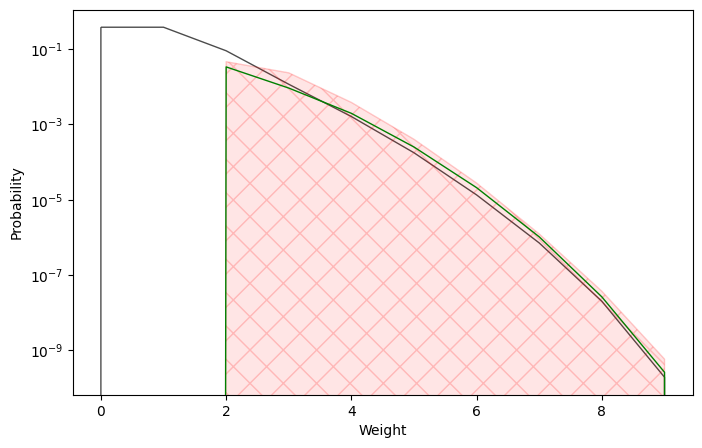

In [562]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

zero = min(bad_prs)
ax.fill_between(weights, np.ones_like(unimportant_prs) * zero, unimportant_prs, label='unimportant', facecolor="none", alpha=0.7)
ax.fill_between(weights, np.ones_like(bad_prs) * zero, bad_prs, label='bad', facecolor="r", hatch="x", edgecolor="r", alpha=0.1)
ax.fill_between(weights, np.ones_like(bad_prs) * zero, bad_prs, facecolor='none', hatch="x", edgecolor="r", alpha=.1) #matplotlib rendering bug https://stackoverflow.com/questions/5195466/matplotlib-does-not-display-hatching-when-rendering-to-pdf
ax.fill_between(weights, np.ones_like(important_prs) * zero, important_prs, label='important', facecolor="none", edgecolor='g', alpha=1, )

ax.set_xlabel("Weight")
ax.set_ylabel("Probability")
ax.semilogy()

In [245]:
print(unimportant_prs)
print(important_prs)
print(bad_prs)

[7.17657949e-01 2.43093313e-01 1.76467564e-02 6.01221729e-04
 2.33991090e-05 7.51503890e-07 1.60727735e-08 2.75013586e-10
 2.51263719e-12 6.93672939e-15]
[0.00000000e+00 0.00000000e+00 5.90335804e-03 3.27378148e-04
 1.85833974e-05 6.37604652e-07 1.51318462e-08 2.37834664e-10
 1.91931891e-12 5.76148556e-15]
[0.00000000e+00 0.00000000e+00 1.24660333e-02 2.13344531e-03
 1.22622930e-04 4.41379954e-06 1.03009003e-07 1.45223964e-09
 1.21085712e-11 4.83369413e-14]


So these still aren't matching. Something is still wrong, and its apprently not from bad tie-breaking.

In [200]:
n = 9
for i, syndrome in enumerate(itertools.product([0, 1], repeat= 8)):
    syndrome = tuple(reversed(syndrome))
    logical_mles = mle_lookup[syndrome]
    logical_mwpm = mwpm_lookup[syndrome]
    if logical_mwpm not in logical_mles:
        print("mismatch for syndrome", syndrome)
        print("mwpm", logical_mwpm)
        print("mles ", logical_mles)
    # print("true", logical_true)

        
    # if i > 10:
    #     break
        # 
        # mwpm_pred = 

In [ ]:
import matplotlib.pyplot as plt
from math import comb


Text(0.5, 0, 'wt(E)')

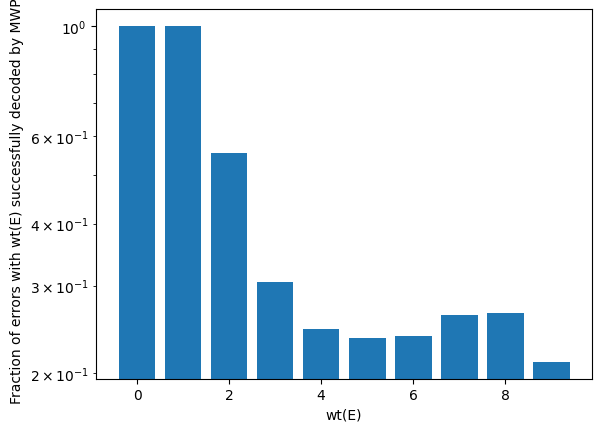

In [58]:
xvals = dct.keys()
yvals = []
for x in xvals:
    factor = comb(9, x) * 3 ** x
    yvals.append(dct[x] / factor)

plt.bar(xvals, yvals)
plt.semilogy()
plt.ylabel("Fraction of errors with wt(E) successfully decoded by MWPM")
plt.xlabel("wt(E)")

<BarContainer object of 10 artists>

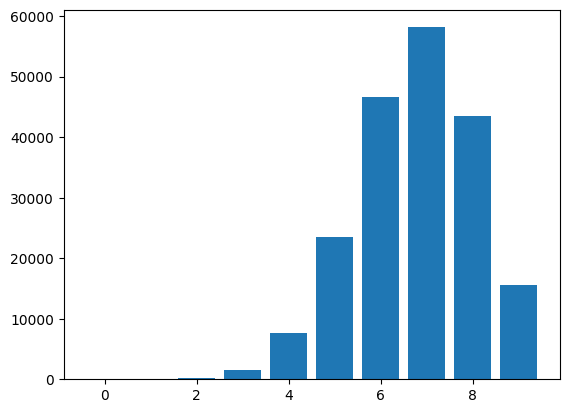

In [ ]:
plt.bar(dct.keys(), dct.values())

In [37]:
print(dct)

None


In [ ]:


from mldec.quantum import pauli_decoding_stim
p_I = 0.99
n = L ** 2
k = 1
temp = []
pvec = [p_I, (1-p_I)/3, (1-p_I)/3, (1-p_I)/3]
error_channel = lambda x: pauli_decoding_stim.pauli_vector_channel(pvec, x, n)
p_SA = pauli_decoding_stim.compute_coset_distribution_pure_errors(generators_S, generators_T, generators_L, error_channel)

mle = pauli_decoding_stim.mle_success_prob(p_SA)
print("Maximum likelihood, L={}".format(L))
print(mle)